# Initial

[-9.12883422  3.81506609 -0.08699267  0.        ]


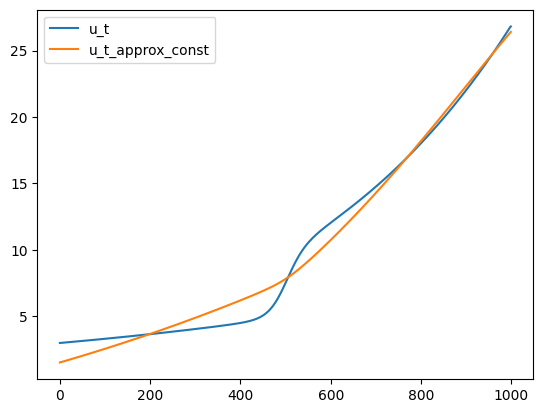

In [12]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

odeint = sp.integrate.odeint
solve_ivp = sp.integrate.solve_ivp

# Integrator keywords for solve_ivp
integrator_keywords = {
    'rtol':1e-12,
    'method':'LSODA',
    'atol':1e-12
}
dt = 1e-3
t = np.arange(0,1,dt)

def k(t):
    return 1.0+1.0/(1.0+np.exp(-50*(t-0.5)))
def non_linear_ode(time,x):
    return 1.0*k(time)*x
t_span = (t[0],t[-1])
x0 = 3.0
num_solution = solve_ivp(non_linear_ode, t_span, [x0], t_eval=t,**integrator_keywords)
u_t = np.gradient(num_solution.y[0],dt,axis=0) # ∂u/∂t

from scipy.linalg import lstsq

def stlsq(Theta, Ut, threshold=0.01, iterations=20):
    xi = lstsq(Theta, Ut)[0]
    for _ in range(iterations):
        small_inds = np.abs(xi) < threshold
        xi[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        xi[big_inds] = lstsq(Theta[:, big_inds], Ut)[0]
    return xi
Theta = np.array([np.ones_like(u),u,u*u,u*(u*u)]).T

xi = stlsq(Theta, u_t, threshold=0.01, iterations=20)
u_t_approx_const = Theta@xi
print(xi)
plt.plot(u_t, label="u_t")
plt.plot(u_t_approx_const, label="u_t_approx_const")
plt.legend()
plt.show()

In [13]:
def objective(params,u_t=u_t,u=u):
    k0,k_values = params[:u.shape[0]],params[u.shape[0]:]
    ut_pred = k0+k_values * u
    return np.sum((u_t-ut_pred)**2)/np.size(u) # MSE

n = u.shape[0]
k_initial = np.random.randn(2*u.shape[0])

results = sp.optimize.minimize(objective,k_initial,method="SLSQP",tol=1e-8)
print(results)
u_t_pred = results.x[:u.shape[0]]+ results.x[u.shape[0]:]* u




     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 1.6267452882527484e-08
           x: [ 8.476e-01  1.021e+00 ...  2.097e+00  1.998e+00]
         nit: 59
         jac: [-7.565e-07 -5.575e-08 ...  7.207e-06  2.327e-06]
        nfev: 118060
        njev: 59
 multipliers: []


# SOlution

In [16]:
import numpy as np
from scipy.optimize import minimize
import scipy.sparse as sparse

def smooth_optimization_with_sindy_prior(u_t, u, t, sindy_xi, alpha=1e-2, beta=1e-1, gamma=1e-3):
    """
    Optimization with smoothness constraints and SINDY prior
    """
    n = len(u)
    
    def objective(params):
        k0 = params[:n]
        k1 = params[n:]
        
        # Data fidelity
        ut_pred = k0 + k1 * u
        data_term = np.mean((u_t - ut_pred)**2)
        
        # Smoothness constraints (finite differences)
        k0_smooth = alpha * np.mean(np.diff(k0)**2)
        k1_smooth = beta * np.mean(np.diff(k1)**2)
        
        # SINDY prior - encourage k1 to be near SINDY coefficient
        sindy_prior = gamma * np.mean((k1 - sindy_xi[1])**2)
        
        # Strong penalty for non-zero k0
        zero_k0_penalty = 10.0 * np.mean(k0**2)
        
        return data_term + k0_smooth + k1_smooth + sindy_prior + zero_k0_penalty
    
    # Build finite difference matrix for regularization
    def build_smoothness_matrix(n, strength):
        D = sparse.diags([-np.ones(n-1), np.ones(n)], [0, 1], shape=(n-1, n))
        return strength * (D.T @ D)
    
    # Initialization: k0 small, k1 from SINDY
    k0_initial = 0.01 * np.ones(n)
    k1_initial = sindy_xi[1] * np.ones(n)
    initial_params = np.concatenate([k0_initial, k1_initial])
    
    # Bounds: k0 near 0, k1 positive and reasonable
    bounds = [(-0.1, 0.1)] * n + [(0.5, 3.0)] * n
    
    result = minimize(objective, initial_params, method='L-BFGS-B', 
                     bounds=bounds, options={'maxiter': 1000})
    
    return result

In [17]:
def reduced_parameter_optimization(u_t, u, t, sindy_xi, n_basis=10):
    """
    Represent k0(t) and k1(t) with reduced basis functions
    """
    # Create basis functions (Fourier, polynomials, etc.)
    def create_basis(t, n_basis):
        basis = []
        # Constant
        basis.append(np.ones_like(t))
        # Fourier basis
        for i in range(1, n_basis):
            if i % 2 == 1:
                basis.append(np.sin(2 * np.pi * (i//2 + 1) * t))
            else:
                basis.append(np.cos(2 * np.pi * (i//2) * t))
        return np.array(basis).T
    
    basis = create_basis(t, n_basis)
    
    def objective(params):
        # params: [k0_coeffs, k1_coeffs]
        k0_coeffs = params[:n_basis]
        k1_coeffs = params[n_basis:2*n_basis]
        
        k0_t = basis @ k0_coeffs
        k1_t = basis @ k1_coeffs
        
        ut_pred = k0_t + k1_t * u
        data_term = np.mean((u_t - ut_pred)**2)
        
        # Strong penalty for k0
        k0_penalty = 10.0 * np.mean(k0_t**2)
        
        # Encourage k1 to be near SINDY value
        sindy_prior = 0.1 * (np.mean(k1_t) - sindy_xi[1])**2
        
        return data_term + k0_penalty + sindy_prior
    
    # Initial guess
    k0_coeffs_initial = np.zeros(n_basis)
    k1_coeffs_initial = np.zeros(n_basis)
    k1_coeffs_initial[0] = sindy_xi[1]  # Constant term from SINDY
    
    initial_params = np.concatenate([k0_coeffs_initial, k1_coeffs_initial])
    
    # Bounds - k0 coefficients very small
    bounds = [(-0.01, 0.01)] * n_basis + [(-5, 5)] * n_basis
    
    result = minimize(objective, initial_params, method='L-BFGS-B', bounds=bounds)
    
    # Reconstruct full functions
    k0_reconstructed = basis @ result.x[:n_basis]
    k1_reconstructed = basis @ result.x[n_basis:2*n_basis]
    
    return result, k0_reconstructed, k1_reconstructed

In [18]:
def alternating_optimization(u_t, u, t, sindy_xi, max_iters=10):
    """
    Alternating optimization: fix k1, optimize k0; then fix k0, optimize k1
    """
    n = len(u)
    k0 = 0.001 * np.ones(n)
    k1 = sindy_xi[1] * np.ones(n)
    
    for iteration in range(max_iters):
        # Step 1: Fix k1, optimize k0 with strong zero constraint
        def objective_k0(k0_params):
            ut_pred = k0_params + k1 * u
            data_term = np.mean((u_t - ut_pred)**2)
            zero_penalty = 100.0 * np.mean(k0_params**2)  # Very strong penalty
            return data_term + zero_penalty
        
        k0_result = minimize(objective_k0, k0, method='L-BFGS-B', 
                           bounds=[(-0.01, 0.01)] * n)
        k0 = k0_result.x
        
        # Step 2: Fix k0, optimize k1 with smoothness
        def objective_k1(k1_params):
            ut_pred = k0 + k1_params * u
            data_term = np.mean((u_t - ut_pred)**2)
            smooth_penalty = 0.1 * np.mean(np.diff(k1_params)**2)
            sindy_prior = 0.01 * np.mean((k1_params - sindy_xi[1])**2)
            return data_term + smooth_penalty + sindy_prior
        
        k1_result = minimize(objective_k1, k1, method='L-BFGS-B',
                           bounds=[(0.5, 3.0)] * n)
        k1 = k1_result.x
        
        print(f"Iteration {iteration}: k0_mean = {np.mean(k0):.4f}, k1_mean = {np.mean(k1):.4f}")
        
        # Check convergence
        if iteration > 0 and np.abs(np.mean(k0) - prev_k0_mean) < 1e-6:
            break
        prev_k0_mean = np.mean(k0)
    
    return k0, k1

SINDY coefficients: [-9.12883422  3.81506609 -0.08699267  0.        ]
=== Approach 1: Smoothness + SINDY Prior ===
=== Approach 2: Reduced Parameter ===
=== Approach 3: Alternating Optimization ===
Iteration 0: k0_mean = -0.0100, k1_mean = 1.5022
Iteration 1: k0_mean = -0.0001, k1_mean = 1.5007
Iteration 2: k0_mean = -0.0000, k1_mean = 1.5007
Iteration 3: k0_mean = -0.0000, k1_mean = 1.5007

Approach 1:
  k0 mean: -0.054565 (should be near 0)
  k1 mean: 1.561729 (SINDY had: 3.815066)
  k0 std: 0.034195 (should be small)
  MSE: 4.06e-01

Approach 2:
  k0 mean: -0.010000 (should be near 0)
  k1 mean: 1.542546 (SINDY had: 3.815066)
  k0 std: 0.018564 (should be small)
  MSE: 3.11e-01

Approach 3:
  k0 mean: -0.000049 (should be near 0)
  k1 mean: 1.500671 (SINDY had: 3.815066)
  k0 std: 0.000027 (should be small)
  MSE: 3.13e-05


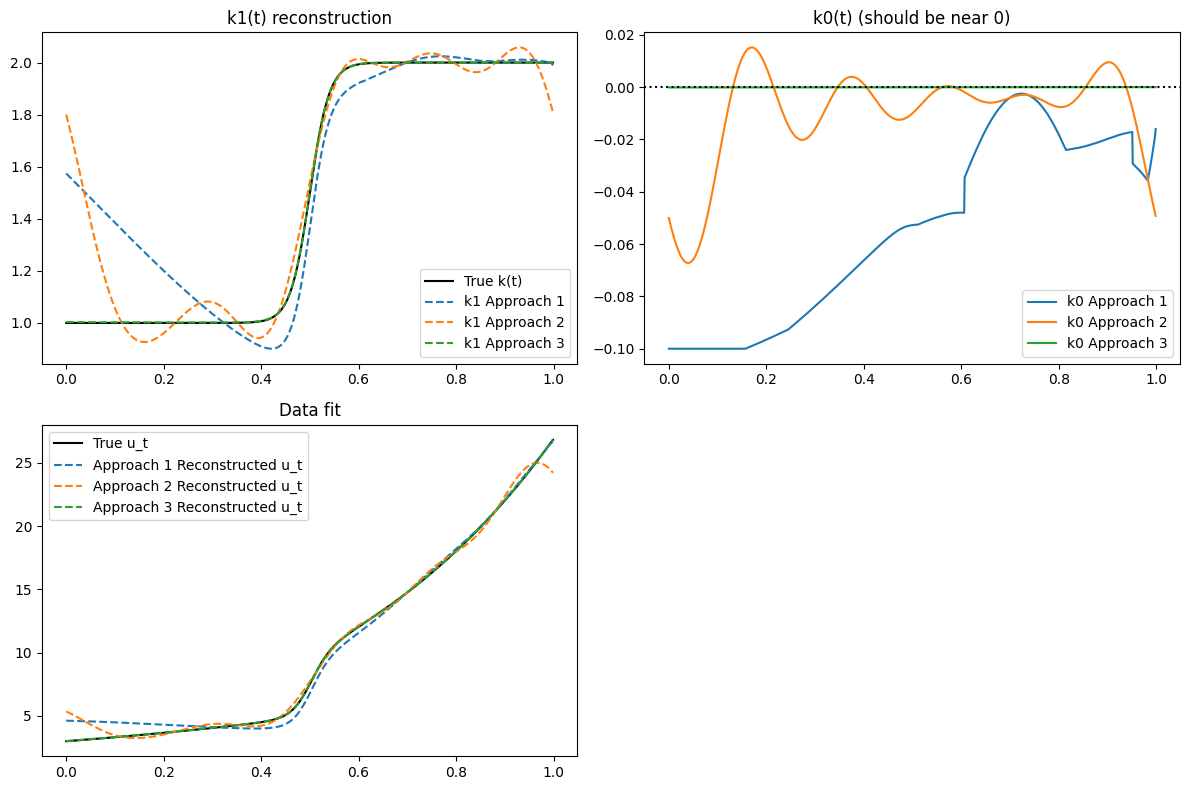

In [22]:
# Your SINDY step first
Theta = np.array([np.ones_like(u), u, u**2, u**3]).T
xi_sindy = stlsq(Theta, u_t, threshold=0.01, iterations=20)
print(f"SINDY coefficients: {xi_sindy}")

# Try different approaches
print("=== Approach 1: Smoothness + SINDY Prior ===")
result1 = smooth_optimization_with_sindy_prior(u_t, u, t, xi_sindy)
k0_1, k1_1 = result1.x[:len(u)], result1.x[len(u):]

print("=== Approach 2: Reduced Parameter ===")
result2, k0_2, k1_2 = reduced_parameter_optimization(u_t, u, t, xi_sindy)

print("=== Approach 3: Alternating Optimization ===")
k0_3, k1_3 = alternating_optimization(u_t, u, t, xi_sindy)
def k_true(t):
    return 1.0+1.0/(1.0+np.exp(-50*(t-0.5)))
# Evaluate results
def evaluate_results(k0, k1, label):
    print(f"\n{label}:")
    print(f"  k0 mean: {np.mean(k0):.6f} (should be near 0)")
    print(f"  k1 mean: {np.mean(k1):.6f} (SINDY had: {xi_sindy[1]:.6f})")
    print(f"  k0 std: {np.std(k0):.6f} (should be small)")
    
    # Reconstruction error
    ut_pred = k0 + k1 * u
    mse = np.mean((u_t - ut_pred)**2)
    print(f"  MSE: {mse:.2e}")

evaluate_results(k0_1, k1_1, "Approach 1")
evaluate_results(k0_2, k1_2, "Approach 2") 
evaluate_results(k0_3, k1_3, "Approach 3")

# Plot comparison
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(t, k_true(t), 'k-', label='True k(t)')
plt.plot(t, k1_1, '--', label='k1 Approach 1')
plt.plot(t, k1_2, '--', label='k1 Approach 2') 
plt.plot(t, k1_3, '--', label='k1 Approach 3')
plt.legend()
plt.title('k1(t) reconstruction')

plt.subplot(2, 2, 2)
plt.plot(t, k0_1, label='k0 Approach 1')
plt.plot(t, k0_2, label='k0 Approach 2')
plt.plot(t, k0_3, label='k0 Approach 3')
plt.axhline(0, color='k', linestyle=':')
plt.legend()
plt.title('k0(t) (should be near 0)')

plt.subplot(2, 2, 3)
plt.plot(t, u_t, label='True u_t',color="black")
plt.plot(t, k0_1 + k1_1 * u, '--', label='Approach 1 Reconstructed u_t')
plt.plot(t, k0_2 + k1_2 * u, '--', label='Approach 2 Reconstructed u_t')
plt.plot(t, k0_3 + k1_3 * u, '--', label='Approach 3 Reconstructed u_t')
plt.legend()
plt.title('Data fit')

plt.tight_layout()
plt.show()